# RCS CNN+LSTM Pipeline (MetaTrader 5, Modular, Broker-Aware)

This notebook demonstrates a robust, modular pipeline for FX prediction using MetaTrader 5 data, advanced feature engineering, deep learning, and feature set analysis.

In [1]:
# --- Data Loading ---
from src.data.loader import load_or_fetch, load_metatrader_data
import pandas as pd

symbols = ["EURUSD", "GBPUSD", "USDJPY", "AUDUSD", "USDCAD", "EURJPY", "GBPJPY"]
provider = "metatrader"
broker = "amp_global"
interval = "H1"

data = {}
for sym in symbols:
    df = load_or_fetch(
        symbol=sym,
        provider=provider,
        loader_func=load_metatrader_data,
        api_key="",
        interval=interval,
        broker=broker,
        force_refresh=False,
    )
    if "time" in df.columns and "close" in df.columns:
        df = df[["time", "open", "high", "low", "close", "tick_volume"]].dropna()
        df["time"] = pd.to_datetime(df["time"])
        df = df.set_index("time")
        for col in ["open", "high", "low", "close", "tick_volume"]:
            data[(sym, col)] = df[col]
prices = pd.DataFrame(data)
print(prices.head())

✅ Loaded cached data from data/metatrader_EURUSD.parquet
✅ Loaded cached data from data/metatrader_GBPUSD.parquet
✅ Loaded cached data from data/metatrader_USDJPY.parquet
✅ Loaded cached data from data/metatrader_AUDUSD.parquet
✅ Loaded cached data from data/metatrader_USDCAD.parquet
✅ Loaded cached data from data/metatrader_EURJPY.parquet
✅ Loaded cached data from data/metatrader_GBPJPY.parquet
                      EURUSD                                        USDJPY  \
                        open     high      low    close tick_volume   open   
time                                                                         
2023-06-09 04:00:00  1.07820  1.07851  1.07796  1.07806      1782.0    NaN   
2023-06-09 05:00:00  1.07806  1.07811  1.07757  1.07768      1398.0    NaN   
2023-06-09 06:00:00  1.07768  1.07802  1.07766  1.07778      1104.0    NaN   
2023-06-09 07:00:00  1.07778  1.07786  1.07747  1.07754       834.0    NaN   
2023-06-09 08:00:00  1.07755  1.07841  1.07754  1.07780

In [2]:
# --- Feature Engineering ---
from src.features.engineering import engineer_features
symbol = "EURUSD"
features = engineer_features(prices, symbol)
print(features.head())

                           rsi      macd  momentum         cci       atr  \
time                                                                       
2023-06-12 05:00:00  31.771996 -0.000881 -0.170125 -118.625425  0.000887   
2023-06-12 06:00:00  34.909370 -0.000867 -0.067918  -95.231219  0.000860   
2023-06-12 07:00:00  35.043400 -0.000846 -0.067918  -77.367399  0.000837   
2023-06-12 08:00:00  45.037563 -0.000754  0.005582  -33.933946  0.000848   
2023-06-12 09:00:00  45.037563 -0.000673 -0.004651   -6.730373  0.000846   

                           adx    stoch_k    stoch_d       roc       bbw  ...  \
time                                                                      ...   
2023-06-12 05:00:00   0.000000  13.002364   6.680063 -0.170125  0.414339  ...   
2023-06-12 06:00:00   0.000000  19.554455  11.337374 -0.067918  0.381928  ...   
2023-06-12 07:00:00  26.635786  29.850746  20.802522 -0.067918  0.379116  ...   
2023-06-12 08:00:00  25.216249  83.076923  44.160708  0.005582

c:\Users\user\Projects\Finance\Strategies\trading-strategies\top5\RCS_CNN_LSTM_Notebook\RCS_CNN_LSTM_Notebook\feature_engineering.py:51: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['return_1d'] = ohlc[(symbol, "close")].pct_change(1)
c:\Users\user\Projects\Finance\Strategies\trading-strategies\top5\RCS_CNN_LSTM_Notebook\RCS_CNN_LSTM_Notebook\feature_engineering.py:52: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['return_3d'] = ohlc[(symbol, "close")].pct_change(3)


In [3]:
# --- Target Creation ---
target = (prices[(symbol, "close")].shift(-1) > prices[(symbol, "close")]).astype(int)
common_index = features.index.intersection(target.index)
features = features.loc[common_index]
target = target.loc[common_index]
print("features shape:", features.shape)
print("target shape:", target.shape)

features shape: (9677, 23)
target shape: (9677,)


In [4]:
# --- Rolling Window, Train/Test Split, Model Training ---
from src.models.utils import create_rolling_windows, train_test_split_rolling, train_cnn_lstm_model, evaluate_cnn_lstm_model
from sklearn.preprocessing import StandardScaler

feature_names = features.columns.tolist()
features_scaled = StandardScaler().fit_transform(features)
lookback = 20
X = create_rolling_windows(features_scaled, lookback)
y = target.values[lookback:]
X_train, X_test, y_train, y_test = train_test_split_rolling(X, y, test_size=0.2)
model, history = train_cnn_lstm_model(X_train, y_train, X_test, y_test, X_train.shape[1:], epochs=10, batch_size=32)
acc, report = evaluate_cnn_lstm_model(model, X_test, y_test)
print("Test accuracy:", acc)
print(report)

Epoch 1/10
242/242 - 6s - 26ms/step - accuracy: 0.4863 - loss: 0.7025 - val_accuracy: 0.4912 - val_loss: 0.6964
Epoch 2/10
242/242 - 2s - 9ms/step - accuracy: 0.5024 - loss: 0.6954 - val_accuracy: 0.5067 - val_loss: 0.6942
Epoch 3/10
242/242 - 2s - 9ms/step - accuracy: 0.5081 - loss: 0.6955 - val_accuracy: 0.4953 - val_loss: 0.6950
Epoch 4/10
242/242 - 2s - 9ms/step - accuracy: 0.5216 - loss: 0.6923 - val_accuracy: 0.5062 - val_loss: 0.6951
Epoch 5/10
242/242 - 2s - 9ms/step - accuracy: 0.5302 - loss: 0.6902 - val_accuracy: 0.5036 - val_loss: 0.6946
Epoch 6/10
242/242 - 3s - 10ms/step - accuracy: 0.5263 - loss: 0.6919 - val_accuracy: 0.4943 - val_loss: 0.6989
Epoch 7/10
242/242 - 2s - 9ms/step - accuracy: 0.5351 - loss: 0.6887 - val_accuracy: 0.5016 - val_loss: 0.6955
Epoch 8/10
242/242 - 2s - 10ms/step - accuracy: 0.5403 - loss: 0.6879 - val_accuracy: 0.4953 - val_loss: 0.7000
Epoch 9/10
242/242 - 2s - 10ms/step - accuracy: 0.5512 - loss: 0.6841 - val_accuracy: 0.4974 - val_loss: 0.70

Evaluating feature set: Indicators only with features: ['rsi', 'macd', 'momentum', 'cci']
Evaluating feature set: All features with features: ['rsi', 'macd', 'momentum', 'cci', 'atr', 'adx', 'stoch_k', 'stoch_d', 'roc', 'bbw', 'return_1d', 'return_3d', 'rolling_mean_5', 'rolling_std_5', 'momentum_slope', 'dxy', '^vix', '^gspc', 'gc=f', 'cl=f', 'gold_oil_ratio', 'day_of_week', 'month']
📁 Saved results to feature_set_results_EURUSD.csv
🏆 Best set saved to best_feature_set_EURUSD.csv
       Feature Set  Accuracy  \
0  Indicators only  0.505694   
1     All features  0.480331   

                                            Features  
0                         [rsi, macd, momentum, cci]  
1  [rsi, macd, momentum, cci, atr, adx, stoch_k, ...  
Epoch 1/10
242/242 - 6s - 25ms/step - accuracy: 0.4902 - loss: 0.7041 - val_accuracy: 0.5124 - val_loss: 0.6935
Epoch 2/10
242/242 - 2s - 9ms/step - accuracy: 0.4977 - loss: 0.6972 - val_accuracy: 0.5114 - val_loss: 0.6938
Epoch 3/10
242/242 - 2s - 9ms

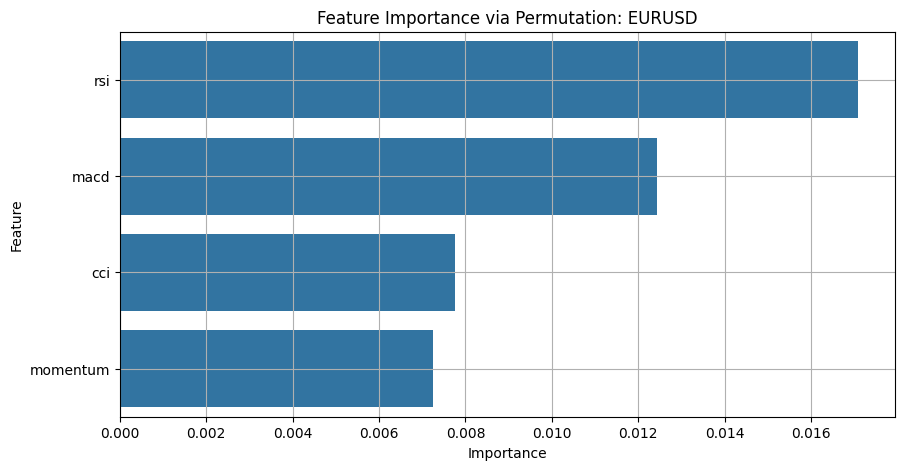

In [5]:
# --- Feature Set Comparison and Permutation Importance ---
from src.features.analysis import compute_permutation_importance, compare_feature_sets, evaluate_and_save_feature_sets

manual_feature_sets = {
    "Indicators only": ['rsi', 'macd', 'momentum', 'cci'],
    "All features": feature_names
}
results_df, best_row = evaluate_and_save_feature_sets(features, y, manual_feature_sets, symbol, lookback_window=lookback, model_fn=None, epochs=10, batch_size=32)
print(results_df)

# Permutation importance for best feature set
best_features = best_row["Features"]
X_best = features[best_features].dropna().values
features_scaled_best = StandardScaler().fit_transform(X_best)
X_seq_best = create_rolling_windows(features_scaled_best, lookback)
y_seq_best = y[-len(X_seq_best):]
split = int(len(X_seq_best) * 0.8)
X_train_best, X_test_best = X_seq_best[:split], X_seq_best[split:]
y_train_best, y_test_best = y_seq_best[:split], y_seq_best[split:]
model_best, _ = train_cnn_lstm_model(X_train_best, y_train_best, X_test_best, y_test_best, X_train_best.shape[1:], epochs=10, batch_size=32)
importances = compute_permutation_importance(model_best, X_test_best, y_test_best, best_features)
importance_df = pd.DataFrame(importances, columns=["Feature", "Importance"])
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(data=importance_df, x="Importance", y="Feature")
plt.title(f"Feature Importance via Permutation: {symbol}")
plt.grid(True)
plt.show()